In [1]:
%matplotlib inline
import sysid
import numpy as np
import scipy
from matplotlib import pyplot as plt

# Experimental Data

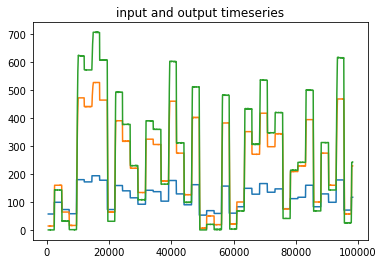

In [2]:
rows_use = 20000
rows_skip = 10
# import the data from the constrained run
data_exp = np.genfromtxt('002.csv',delimiter=',',dtype=int,
                        skip_header=100,max_rows=rows_use,invalid_raise=False)

data_exp = data_exp[::10]

# plot the raw timeseries
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(data_exp[:,0],data_exp[:,1])
ax.plot(data_exp[:,0],data_exp[:,2])
ax.plot(data_exp[:,0],data_exp[:,3])
ax.set_title("input and output timeseries")

t_exp = np.asmatrix(data_exp[:,0])
u_exp = np.asmatrix(data_exp[:,1] - 50)
y1_exp = np.asmatrix(data_exp[:,2])
y2_exp = np.asmatrix(data_exp[:,3])
y12_exp = np.stack((y1_exp,y2_exp),axis=0)

time_duration = t_exp[0,-1]-t_exp[0,0]
dt = (time_duration / rows_use) * rows_skip

### Extract and plot information about this system's equilibrium states

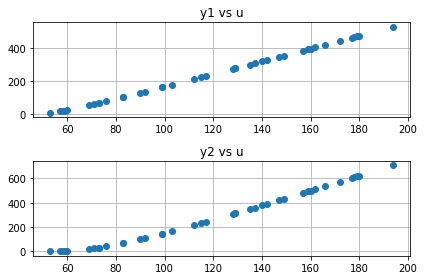

In [3]:
lineprev = None
equilib = None
iprev = None

for line in data_exp:
    i = line[1]
    line = np.array([line])
    try:
        iprev = lineprev[0,1]
    except:
        pass
    if i != iprev and lineprev is not None:
        if equilib is None:
            equilib = lineprev
        else:
            equilib = np.append(equilib,lineprev,axis=0)
    lineprev = line

# plot equilibrium values, inputs vs outputs
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
ax.plot(equilib[:,1],equilib[:,2],marker='o',linestyle='None')
ax.grid()
ax.set_title("y1 vs u")
ax2 = fig.add_subplot(2,1,2)
ax2.plot(equilib[:,1],equilib[:,3],marker='o',linestyle='None')
ax2.grid()
ax2.set_title("y2 vs u")
fig.tight_layout()

### Perform subspace identification

In [21]:
ss_id = sysid.subspace_det_algo1(y12_exp, u_exp, f=8, p=8, s_tol=1e-1, dt=dt, nx=5)

def f_u(t, x, i):
    return u_exp[0,i]
data_exp_id = ss_id.simulate(f_u=f_u, x0=np.matrix([0] * ss_id.A.shape[0]).T, tf=time_duration)

order 2 calculated, but order 5 specified!
n_x:5, n_u:1, n_y:2


fit, y1: 98.606651%
fit, y1: 96.991162%


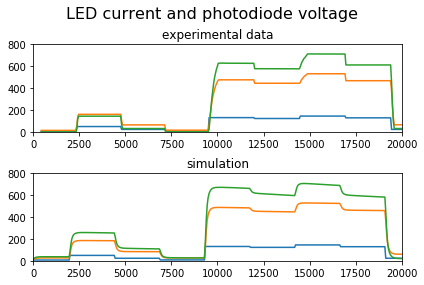

In [22]:
t = np.array(t_exp)[0]
u = np.array(u_exp)[0]
y1 = np.array(y1_exp)[0]
y2 = np.array(y2_exp)[0]
t_id = np.array(data_exp_id.t)[0]
u_id = np.array(data_exp_id.u)[0]
y1_id = np.array(data_exp_id.y[0])[0]
y2_id = np.array(data_exp_id.y[1])[0]

fig = plt.figure()
fig.suptitle("LED current and photodiode voltage", fontsize=16)
ax1 = fig.add_subplot(2,1,1)
ax1.plot(t,u)
ax1.plot(t,y1)
ax1.plot(t,y2)
ax1.set_xlim([0,20000])
ax1.set_ylim([0,800])
ax1.set_title("experimental data")
ax2 = fig.add_subplot(2,1,2)
ax2.plot(t_id,u_id)
ax2.plot(t_id,y1_id)
ax2.plot(t_id,y2_id)
ax2.set_xlim([0,20000])
ax2.set_ylim([0,800])
ax2.set_title("simulation")
fig.tight_layout()
fig.subplots_adjust(top=0.85)

print('fit, y1: {:f}%'.format(100*sysid.subspace.nrms(y1_id,y1_exp)))
print('fit, y1: {:f}%'.format(100*sysid.subspace.nrms(y2_id,y2_exp)))